In [1]:
!pip install datasets
!pip install transformers
!pip install scikit-learn


Train size: 89771
Test size: 9975

Columns: Index(['sentence', 'emotion'], dtype='object')


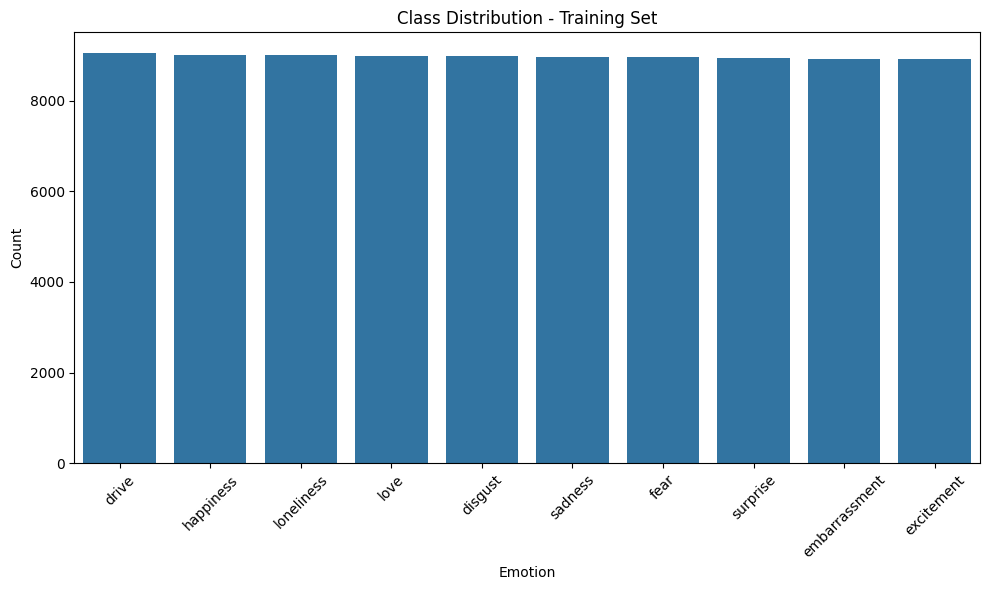


Class Percentage Distribution:
emotion
drive            10.09
happiness        10.03
loneliness       10.03
love             10.01
disgust          10.00
sadness           9.99
fear              9.99
surprise          9.97
embarrassment     9.94
excitement        9.94
Name: proportion, dtype: float64


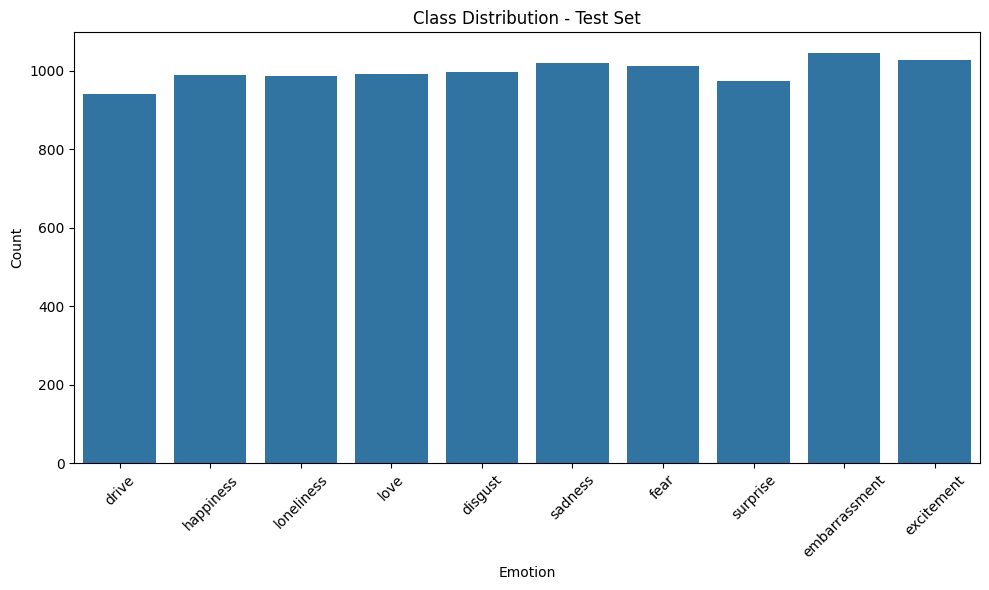

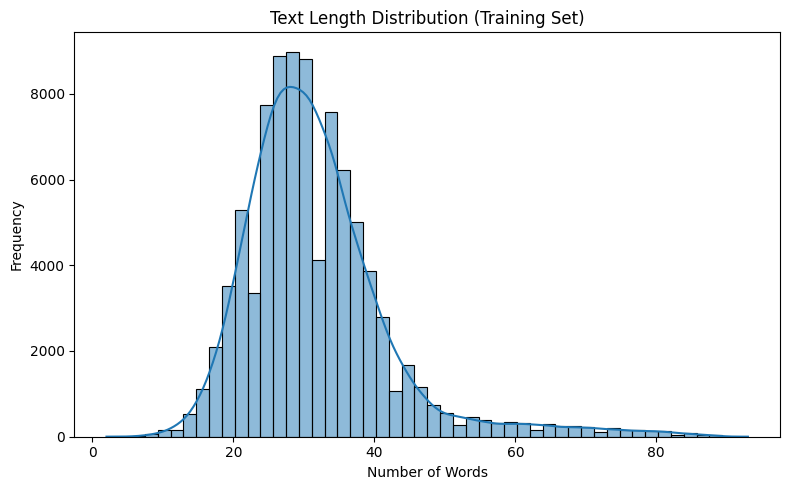


Average Text Length: 31.8
Max Text Length: 93
Min Text Length: 2

Labels: ['disgust', 'drive', 'embarrassment', 'excitement', 'fear', 'happiness', 'loneliness', 'love', 'sadness', 'surprise']
Number of classes: 10


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
dataset = load_dataset("shreyaspullehf/emotion_dataset_100k")
dataset = dataset["train"].train_test_split(test_size=0.1)

train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("\nColumns:", train_df.columns)

# =========================
# 1️⃣ Class Distribution (Counts)
# =========================

plt.figure(figsize=(10,6))
sns.countplot(
    x="emotion",
    data=train_df,
    order=train_df["emotion"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Class Distribution - Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =========================
# 2️⃣ Class Distribution (Percentage)
# =========================

class_percent = train_df["emotion"].value_counts(normalize=True) * 100
print("\nClass Percentage Distribution:")
print(class_percent.round(2))

# =========================
# 3️⃣ Train vs Test Comparison
# =========================

plt.figure(figsize=(10,6))
sns.countplot(
    x="emotion",
    data=test_df,
    order=train_df["emotion"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Class Distribution - Test Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =========================
# 4️⃣ Text Length Analysis
# =========================

train_df["text_length"] = train_df["sentence"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df["text_length"], bins=50, kde=True)
plt.title("Text Length Distribution (Training Set)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("\nAverage Text Length:", round(train_df["text_length"].mean(), 2))
print("Max Text Length:", train_df["text_length"].max())
print("Min Text Length:", train_df["text_length"].min())

# =========================
# Label Setup
# =========================

label_names = sorted(train_df["emotion"].unique())
num_labels = len(label_names)

print("\nLabels:", label_names)
print("Number of classes:", num_labels)


### Class Imbalance Analysis

The dataset does not exhibit significant class imbalance. The distribution of samples across all 10 emotion classes is relatively uniform, with each class containing approximately a similar number of instances. 

Because of this balanced distribution, the model is less likely to develop bias toward any dominant class during training, and weighted evaluation metrics are appropriate for performance reporting.


In [3]:
# Create label mapping
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for label, idx in label2id.items()}

# Convert labels to integers
dataset = dataset.map(lambda x: {"emotion": label2id[x["emotion"]]})


Map:   0%|          | 0/89771 [00:00<?, ? examples/s]

Map:   0%|          | 0/9975 [00:00<?, ? examples/s]

In [4]:

dataset["train"] = dataset["train"].shuffle(seed=42).select(range(30000))


In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(
        example["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9975 [00:00<?, ? examples/s]

In [6]:
tokenized_dataset = tokenized_dataset.rename_column("emotion", "labels")
tokenized_dataset = tokenized_dataset.remove_columns(["sentence"])
tokenized_dataset.set_format("torch")


In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
test_loader = DataLoader(tokenized_dataset["test"], batch_size=32)


In [8]:
import torch
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_names)
)

model.to(device)


2026-02-15 13:31:13.262012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771162273.470556      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771162273.533367      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771162274.049353      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771162274.049392      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771162274.049395      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)


In [10]:
from tqdm import tqdm

epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} Average Loss: {avg_loss:.4f}")


100%|██████████| 938/938 [09:38<00:00,  1.62it/s]



Epoch 1 Average Loss: 0.4708


100%|██████████| 938/938 [09:55<00:00,  1.58it/s]


Epoch 2 Average Loss: 0.1216



===== Overall Evaluation Metrics =====
Accuracy:  0.9419
Precision: 0.9436
Recall:    0.9419
F1 Score:  0.9419

===== Per-Class Metrics =====
               precision    recall  f1-score   support

      disgust       0.98      0.98      0.98       996
        drive       0.96      0.94      0.95       939
embarrassment       0.98      0.98      0.98      1045
   excitement       0.96      0.91      0.93      1027
         fear       0.92      0.99      0.95      1011
    happiness       0.95      0.93      0.94       988
   loneliness       0.88      0.95      0.92       986
         love       0.99      0.94      0.97       991
      sadness       0.95      0.85      0.90      1018
     surprise       0.87      0.94      0.90       974

     accuracy                           0.94      9975
    macro avg       0.94      0.94      0.94      9975
 weighted avg       0.94      0.94      0.94      9975



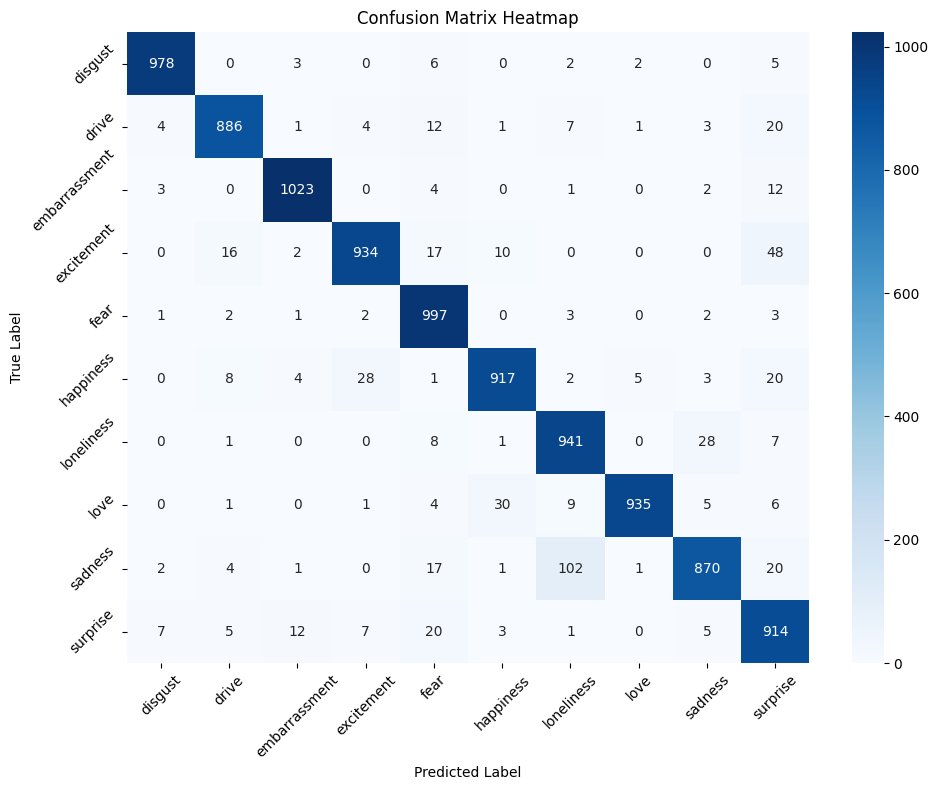

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        logits = outputs.logits
        
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# =========================
# Overall Metrics
# =========================

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="weighted"
)

print("\n===== Overall Evaluation Metrics =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# =========================
# Per-Class Report
# =========================

print("\n===== Per-Class Metrics =====")
print(classification_report(all_labels, all_preds, target_names=label_names))

# =========================
# Confusion Matrix
# =========================

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
import torch.nn.functional as F

def predict_text(text):
    model.eval()
    
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        
    confidence, pred = torch.max(probs, dim=1)
    
    return label_names[pred.item()], confidence.item()


In [19]:
print(predict_text("I’ve been working toward this goal for years."))
print(predict_text("I can't wait for tomorrow!"))
print(predict_text("This is the best day of my life."))
print(predict_text("I can't believe I said that out loud."))
print(predict_text("I feel deeply connected to you."))
print(predict_text("Even in a crowded room, I felt alone."))
print(predict_text("That smell made me feel sick."))


('drive', 0.9917317032814026)
('excitement', 0.9884340167045593)
('happiness', 0.995598316192627)
('embarrassment', 0.891078531742096)
('love', 0.9979701638221741)
('loneliness', 0.9828740358352661)
('disgust', 0.9980308413505554)


In [20]:
print(predict_text("""
I worked incredibly hard for this opportunity.
Now that it's finally here, I feel proud but also nervous about what comes next.
"""))


('fear', 0.5587621331214905)


In mixed-emotion sentences, the model tends to prioritize the most semantically dominant emotional cue (e.g., "nervous" leading to fear). The moderate confidence score (0.55) indicates uncertainty, reflecting the complexity of multi-emotion contexts in single-label classification.